## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [11]:
%pip install requests wget pandas seaborn duckdb

import os
import requests
import wget  # pip install wget
import pandas as pd
import seaborn as sns
import duckdb
import matplotlib.pyplot as plt
import gzip

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load data

In [12]:
# Define folder and file info
folder_path = "data"
file_name = "sc-transcriptomics-cell-instances.csv.gz"
file_name_expanded = "sc-transcriptomics-cell-instances.csv"
file_url = "https://zenodo.org/records/15786154/files/sc-transcriptomics-cell-instances.csv.gz?download=1"
file_path = os.path.join(folder_path, file_name)

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Download only if file is missing
if not os.path.exists(file_path):
    print(f"Downloading {file_name}...")
    wget.download(file_url, out=file_path, bar=None)  # no progress bar
    print("\nDownload complete.")
else:
    print("File already exists, skipping download.")

File already exists, skipping download.


In [13]:
with gzip.open(file_path, "rb") as f_in, open(
    f"{folder_path}/{file_name_expanded}", "wb"
) as f_out:
    while chunk := f_in.read(1024 * 1024):  # 1 MB chunks
        f_out.write(chunk)

## Preprocess data with `duckdb`

In [14]:
dtype_dict = {
    "organ": "str",
    "tool": "category",
    "cell": "str",
    "confidence_score": "float32",
}

df = pd.read_csv(
    file_path,
    compression="gzip",
    dtype=dtype_dict,
    # usecols=dtype_dict.keys()
)
df

,dataset,organ,tool,cell,cell_id,cell_label,match_type,confidence_score
0,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,covid_555_1.1,CL:0000232,erythrocyte,skos:exactMatch,1.000000
1,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACAGCCATCTAGCA,CL:0000625,"CD8-positive, alpha-beta T cell",skos:exactMatch,0.333333
2,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,popv,AAACCTGGTTGTGGCC-1-HCATisStab7509734,CL:0002144,capillary endothelial cell,skos:exactMatch,1.000000
3,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,NaN,CL:0000814,mature NK T cell,skos:exactMatch,1.000000
4,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACATGCAATAATCC,CL:1000320,large intestine goblet cell,skos:exactMatch,0.500000
...,...,...,...,...,...,...,...,...
69582058,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAACCACA,CL:0002063,AT2,skos:exactMatch,0.388534
69582059,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAAGGAGC,CL:0002063,AT2,skos:exactMatch,0.624827
69582060,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAGCGTTA,CL:4028002,EC general capillary,skos:exactMatch,0.290839
69582061,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACATACCAA,CL:0002063,AT2,skos:exactMatch,0.553495


In [15]:
# Combine cell instances and normalize columns for analysis
data_dir = folder_path
query = f"""
SELECT
  dataset as dataset,
  organ as organ,
  tool tool,
  cell as cell,
  cell_id as cell_id,
  cell_label as cell_label,
  match_type,
  confidence_score as confidence_score,
FROM read_csv('data/{ file_name_expanded }', union_by_name = true, filename = true, ignore_errors=true, quote='"')
"""

cells = duckdb.sql(query)
cells.write_csv(f"{ data_dir }/cell-instances.csv.gz")
cells.show()

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────┬────────────┬──────────────────────────────────────────┬──────────────────┬────────────────────────────────────────┬──────────────────┬────────────────────┐
│                                                               dataset                                                                │     organ      │    tool    │                   cell                   │     cell_id      │               cell_label               │    match_type    │  confidence_score  │
│                                                               varchar                                                                │    varchar     │  varchar   │                 varchar                  │     varchar      │                varchar                 │     varchar      │       double       │
├─────────────────────────────────────────────────────────────────────

In [16]:
df_confidence = cells.to_df()
df_confidence.head()

,dataset,organ,tool,cell,cell_id,cell_label,match_type,confidence_score
0,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,covid_555_1.1,CL:0000232,erythrocyte,skos:exactMatch,1.000000
1,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACAGCCATCTAGCA,CL:0000625,"CD8-positive, alpha-beta T cell",skos:exactMatch,0.333333
2,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,popv,AAACCTGGTTGTGGCC-1-HCATisStab7509734,CL:0002144,capillary endothelial cell,skos:exactMatch,1.000000
3,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,None,CL:0000814,mature NK T cell,skos:exactMatch,1.000000
4,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACATGCAATAATCC,CL:1000320,large intestine goblet cell,skos:exactMatch,0.500000


In [17]:
df_confidence

,dataset,organ,tool,cell,cell_id,cell_label,match_type,confidence_score
0,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,covid_555_1.1,CL:0000232,erythrocyte,skos:exactMatch,1.000000
1,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACAGCCATCTAGCA,CL:0000625,"CD8-positive, alpha-beta T cell",skos:exactMatch,0.333333
2,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,popv,AAACCTGGTTGTGGCC-1-HCATisStab7509734,CL:0002144,capillary endothelial cell,skos:exactMatch,1.000000
3,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,None,CL:0000814,mature NK T cell,skos:exactMatch,1.000000
4,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACATGCAATAATCC,CL:1000320,large intestine goblet cell,skos:exactMatch,0.500000
...,...,...,...,...,...,...,...,...
69582058,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAACCACA,CL:0002063,AT2,skos:exactMatch,0.388534
69582059,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAAGGAGC,CL:0002063,AT2,skos:exactMatch,0.624827
69582060,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAGCGTTA,CL:4028002,EC general capillary,skos:exactMatch,0.290839
69582061,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACATACCAA,CL:0002063,AT2,skos:exactMatch,0.553495


## Visualize

In [18]:
sns.set_theme(rc={"figure.figsize": (16, 8)})

plt.rcParams.update(
    {
        "font.size": 17,  # Controls default text size
        "axes.labelsize": 20,  # Controls axes label size
        "xtick.labelsize": 17,  # Controls x-axis tick label size
        "ytick.labelsize": 17,  # Controls y-axis tick label size
        "legend.fontsize": 20,
    }
)  # Controls legend font size

Text(0, 0.5, '# of Cells')

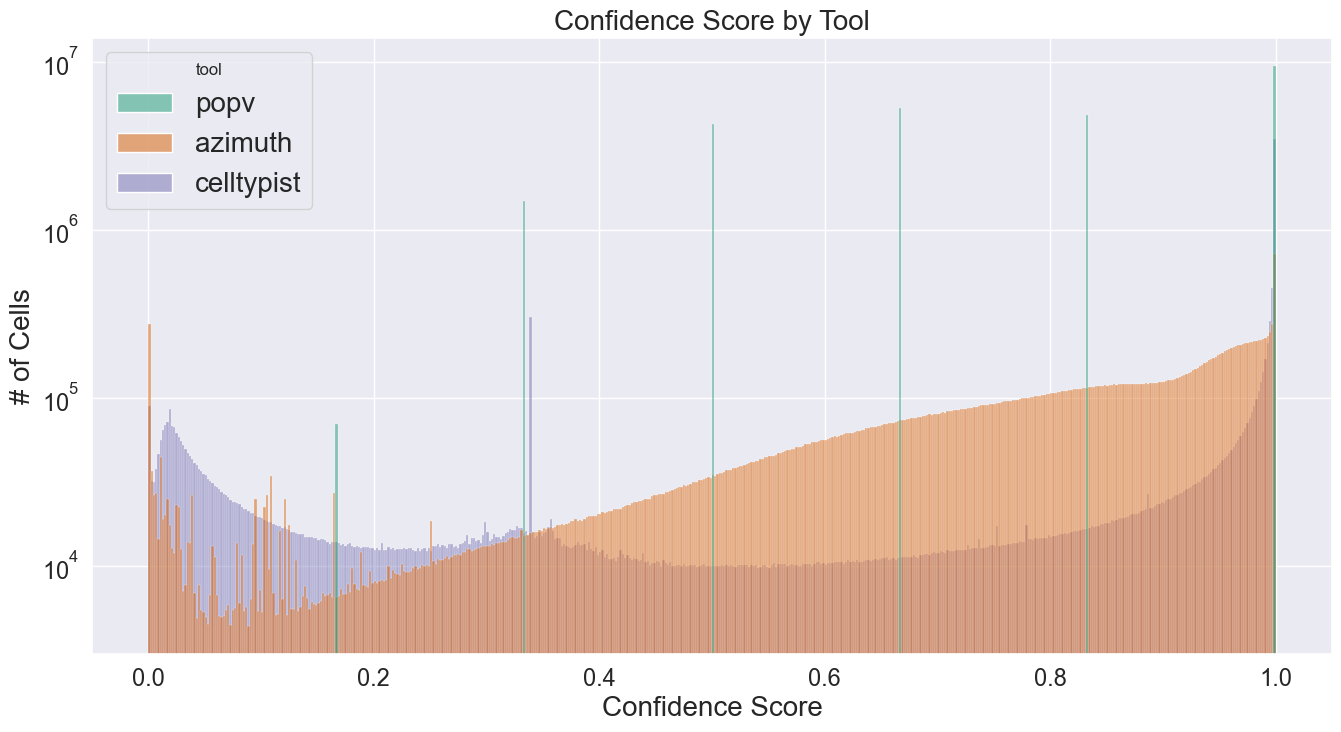

In [19]:
# make plot
g = sns.histplot(
    data=df_confidence,
    x="confidence_score",
    binwidth=0.002,
    hue="tool",
    palette="Dark2",
)

# Set the style to white
sns.set_style("white")

# adjust scales
plt.yscale("log")

# adjust labels++
plt.title("Confidence Score by Tool", fontsize=20)
plt.xlabel("Confidence Score")
plt.ylabel("# of Cells")

In [20]:
# unique cell instances
df_confidence["cell"].nunique()

22425542